In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ds = pd.read_csv('glass.csv')

# Описание данных

* Id number: 1 to 214 (removed from CSV file)
* RI: refractive index
* Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
* Mg: Magnesium
* Al: Aluminum
* Si: Silicon
* K: Potassium
* Ca: Calcium
* Ba: Barium
* Fe: Iron
* Type of glass: (class attribute)
  1. building_windows_float_processed
  2. building_windows_non_float_processed
  3. vehicle_windows_float_processed
  4. vehicle_windows_non_float_processed (none in this database)
  5. containers
  6. tableware
  7. headlamps

# Распределения величин

/home/egor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


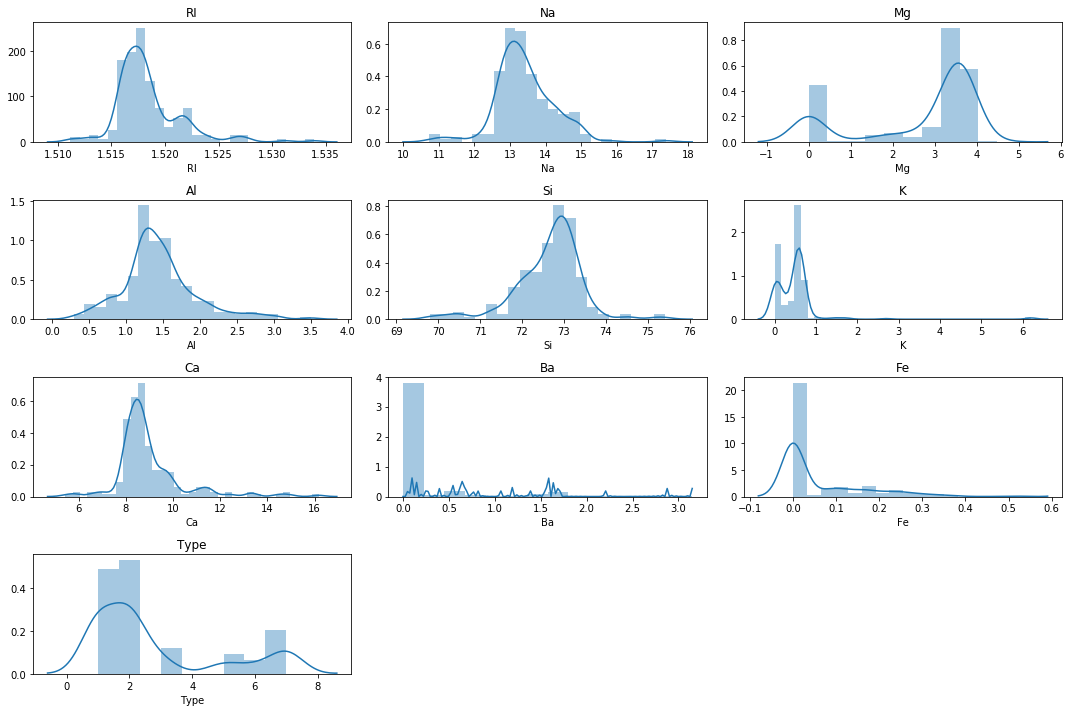

In [3]:
plt.figure(figsize=(15,10))
for idx, c in enumerate(ds.columns):
    plt.subplot(ds.shape[1]//3+1,3,idx+1)
    plt.title(c)
    sns.distplot(ds[c])
plt.tight_layout()
plt.show()

Видны распределения:
* Логнормальное - RI, Na, Ca, Fe
* Нормальное - Si
* Равномерное - Ba
* Смесь нескольких распределений - Mg

Type - признак категориальный поэтому не стоит обращать внимание на то, что его график похож на смесь двух нормальных распределений

# Пропуски в данных

In [4]:
ds.isnull().sum().sum()

0

Т.е. пропуски отсутствуют

In [5]:
(ds[ds.drop('Type',axis=1).columns]<0).sum().sum()

0

Данные могли быть предварительно обработанны, тогда вместо пропусков стояли бы неестественные значения. Например -1 для столбцов, означающих содержание веществ. Таких значений тоже нет.

# Обогащение данных

In [9]:
X_train_enrich = X_train.copy()
X_test_enrich = X_test.copy()

Логарифмируем величины, распределённые логнормально

In [10]:
for f in ['RI', 'Na', 'Ca', 'Fe']:
    X_train_enrich[f+'_log'] = np.log1p(X_train_enrich[f])
    X_train_enrich = X_train_enrich.drop(f,axis=1)
    X_test_enrich[f+'_log'] = np.log1p(X_test_enrich[f])
    X_test_enrich = X_test_enrich.drop(f,axis=1)

Посмотрим как зависит целевая переменная Type от остальных признаков

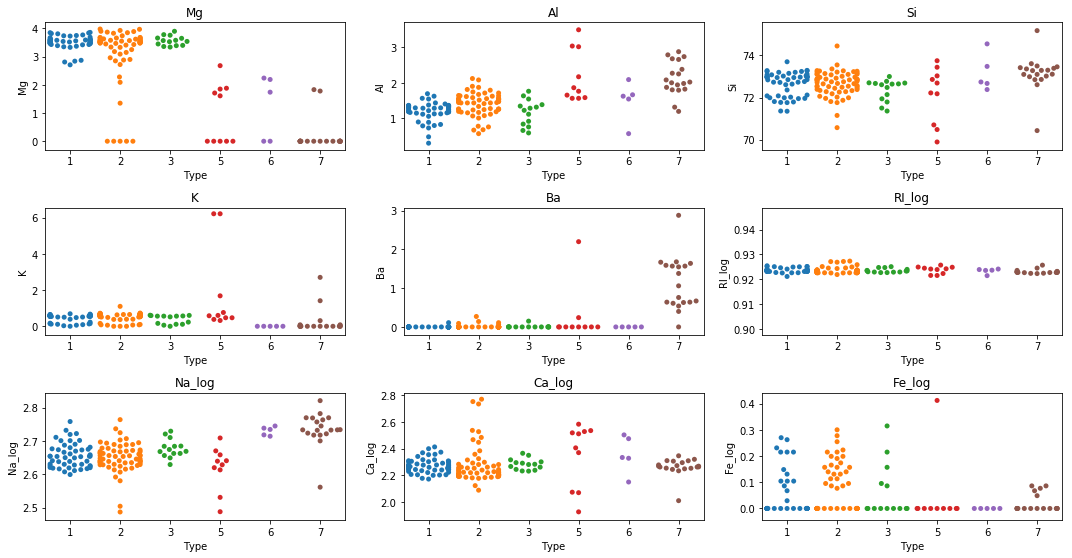

In [11]:
plt.figure(figsize=(15,10))
for idx,c in enumerate(X_train_enrich.columns):
    plt.subplot(len(X_train_enrich.columns)//3+1, 3, idx+1)
    sns.swarmplot(x=Y_train,y=c, data=X_train_enrich)
    plt.title(c)
plt.tight_layout()
plt.show()

Mg, Ba и Fe_lof часто бывают равны 0. Учтём это в данных.
Остальные зависимости модель должа отловить сама.

In [12]:
for f in ['Mg','Ba','Fe_log']:
    X_train_enrich[f+'0'] = (X_train_enrich[f]==0).astype(int)
    X_test_enrich[f+'0'] = (X_test_enrich[f]==0).astype(int)

Посмотрим на взаимодействие переменных

/home/egor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/egor/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/egor/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/egor/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


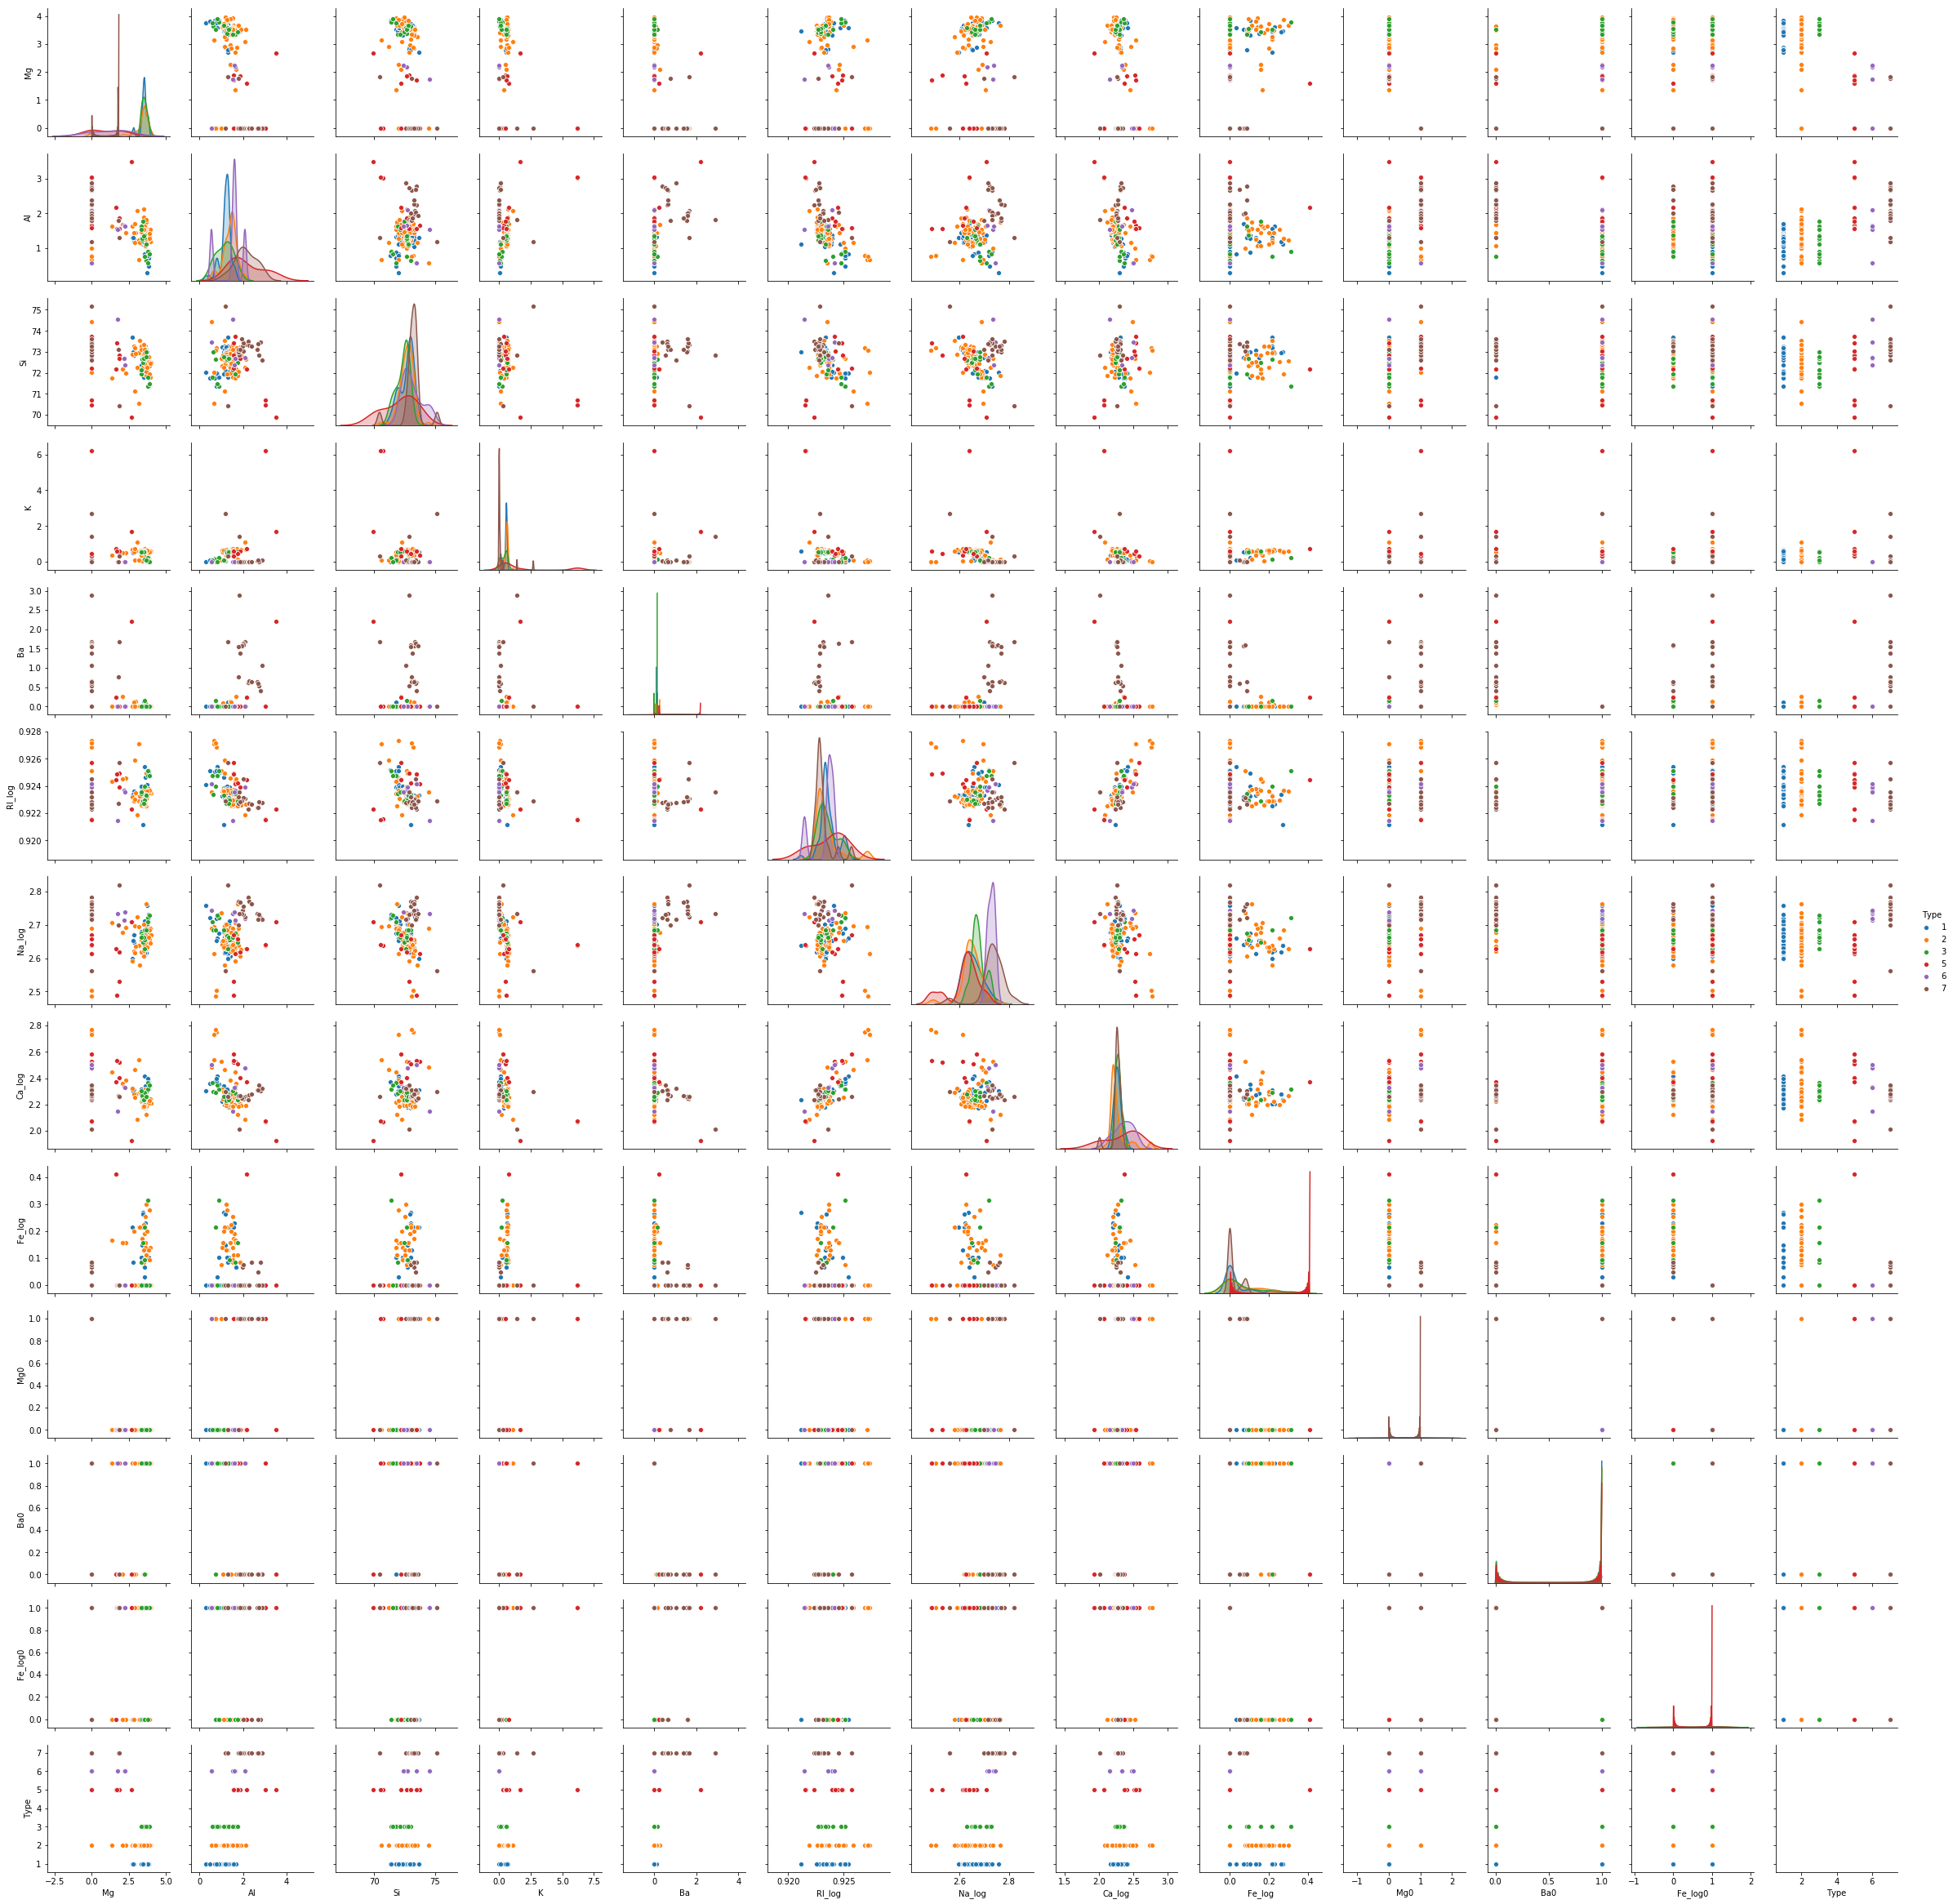

In [13]:
cds = X_train_enrich.copy()
cds['Type'] = Y_train
sns.pairplot(cds, hue='Type')
plt.show()

Взаимодействия признаков не позволяют точно отделить один класс от другого.

Значения Si и Ca линейно зависят от RI. Насколько сильна корреляция между ними?

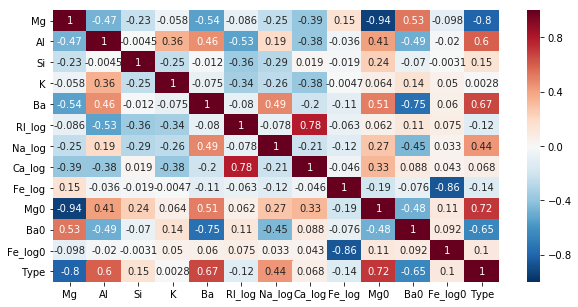

In [14]:
plt.figure(figsize=(10,5))
sns.heatmap(cds.corr(), cmap='RdBu_r', center=0, annot=True, vmin=-1, vmax=1)

Корреляция между RI и Ca и правда большая. По swarmplot выше кажется, что Ca лучше способен отделить классы друг от друга, поэтому уберём RI.

In [15]:
X_train_enrich = X_train_enrich.drop('RI_log',axis=1)
X_test_enrich = X_test_enrich.drop('RI_log',axis=1)

В датасете нет категориальных признаков (кроме целевой переменной), зато много числовых. Попробуем их отмасштабировать.

Т.к. многие числовых признаков распределены нормально или близко к нормальному, используем StandardScaler

In [16]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [17]:
real_feats = ['Na_log','Mg','Al','Si','K','Ca_log','Ba','Fe_log']
scal = StandardScaler()
X_train_enrich_scal = X_train_enrich.copy()
X_test_enrich_scal = X_test_enrich.copy()
X_train_enrich_scal[real_feats] = scal.fit_transform(X_train_enrich[real_feats])
X_test_enrich_scal[real_feats] = scal.transform(X_test_enrich[real_feats])